<a href="https://colab.research.google.com/github/duybluemind1988/Data-science/blob/master/Pytorch/Pytorch_binary_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lower back pain symptoms

https://towardsdatascience.com/pytorch-tabular-binary-classification-a0368da5bb89

https://www.kaggle.com/sammy123/lower-back-pain-symptoms-dataset

# Get Data

In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import balanced_accuracy_score,matthews_corrcoef

310 Observations, 13 Attributes (12 Numeric Predictors, 1 Binary Class Attribute - No Demographics)

Lower back pain can be caused by a variety of problems with any parts of the complex, interconnected network of spinal muscles, nerves, bones, discs or tendons in the lumbar spine. Typical sources of low back pain include:

- The large nerve roots in the low back that go to the legs may be irritated
- The smaller nerves that supply the low back may be irritated
- The large paired lower back muscles (erector spinae) may be strained
- The bones, ligaments or joints may be damaged
- An intervertebral disc may be degenerating

An irritation or problem with any of these structures can cause lower back pain and/or pain that radiates or is referred to other parts of the body. Many lower back problems also cause back muscle spasms, which don't sound like much but can cause severe pain and disability.

While lower back pain is extremely common, the symptoms and severity of lower back pain vary greatly. A simple lower back muscle strain might be excruciating enough to necessitate an emergency room visit, while a degenerating disc might cause only mild, intermittent discomfort.

This data set is about to identify a person is abnormal or normal using collected physical spine details/data.

In [5]:
df = pd.read_csv("/content/drive/My Drive/Data/Dataset_spine.csv")
df=df.iloc[:,:-1]
print(df.shape)
df.head()

(310, 13)


,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12,Class_att
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.254400,0.744503,12.5661,14.5386,15.30468,-28.658501,43.5123,Abnormal
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,0.415186,12.8874,17.5323,16.78486,-25.530607,16.1102,Abnormal
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,0.474889,26.8343,17.4861,16.65897,-29.031888,19.2221,Abnormal
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,0.369345,23.5603,12.7074,11.42447,-30.470246,18.8329,Abnormal
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,0.543360,35.4940,15.9546,8.87237,-16.378376,24.9171,Abnormal


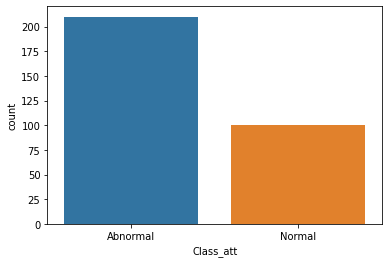

In [6]:
sns.countplot(x = 'Class_att', data=df)

In [7]:
df['Class_att'] = df['Class_att'].astype('category')
encode_map = {
    'Abnormal': 1,
    'Normal': 0
}

df['Class_att'].replace(encode_map, inplace=True)

In [8]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

In [10]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)


## Define Custom Dataloaders

In [11]:
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [12]:
## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = trainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train))
## test data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = testData(torch.FloatTensor(X_test))

In [13]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

## Define Neural network

Once we’ve defined all these layers, it’s time to use them. In the forward() function, we take variable inputs as our input. We pass this input through the different layers we initialized.

The first line of the forward() functions takes the input, passes it through our first linear layer and then applies the ReLU activation on it. Then we apply BatchNorm on the output. Look at the following code to understand it better.

In [14]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(12, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

Once, we’ve defined our architecture, we check if our GPU is active. The amazing thing about PyTorch is that it’s super easy to use the GPU.
The variable device will either say cuda:0 if we have the GPU. If not, it’ll say cpu . You can follow along this tutorial even if you do not have a GPU without any change in code.

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Note that we did not use the Sigmoid activation in our final layer during training. That’s because, we use the nn.BCEWithLogitsLoss() loss function which automatically applies the the Sigmoid activation. We however, need to use Sigmoid manually during inference.

Next, we need to initialize our model. After initializing it, we move it to device . Now, this device is a GPU if you have one or it’s CPU if you don’t. The network we’ve used is fairly small. So, it will not take a lot of time to train on a CPU.

In [16]:
model = binaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=12, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


## Train model

Before we start the actual training, let’s define a function to calculate accuracy.

In the function below, we take the predicted and actual output as the input. The predicted value(a probability) is rounded off to convert it into either a 0 or a 1.

Once that is done, we simply compare the number of 1/0 we predicted to the number of 1/0 actually present and calculate the accuracy.

Note that the inputs y_pred and y_test are for a batch. Our batch_size was 64. So, this accuracy is being calculated for 64 predictions(tensors) at a time.

In [17]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

You can see we’ve put a model.train() at the before the loop. model.train() tells PyTorch that you’re in training mode.

Well, why do we need to do that? If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, so, you don’t explicitly have to write that. But it’s good practice.

Similarly, we’ll call model.eval() when we test our model. We’ll see that below.

Back to training; we start a for-loop. At the top of this for-loop, we initialize our loss and accuracy per epoch to 0. After every epoch, we’ll print out the loss/accuracy and reset it back to 0.

Then we have another for-loop. This for-loop is used to get our data in batches from the train_loader.

We do optimizer.zero_grad() before we make any predictions. Since the backward() function accumulates gradients, we need to set it to 0 manually per mini-batch.

From our defined model, we then obtain a prediction, get the loss(and accuracy) for that mini-batch, perform backpropagation using loss.backward() and optimizer.step() . Finally, we add all the mini-batch losses (and accuracies) to obtain the average loss (and accuracy) for that epoch.

This loss and accuracy is printed out in the outer for loop.

In [18]:
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        #Get the input, data is a list of [inputs, labels], transfer to GPU
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        #1. Initialise gradients 
        optimizer.zero_grad()
        #2 Forward pass
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        #3 Backward
        loss.backward()
        #4 Copute the loss and update the weights
        optimizer.step()
        
        epoch_loss += loss.item() # Loss each batch
        epoch_acc += acc.item() # acc each batch
        
    # Loss and acc per each Eposhs
    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.71094 | Acc: 55.250
Epoch 002: | Loss: 0.60093 | Acc: 66.500
Epoch 003: | Loss: 0.53208 | Acc: 76.500
Epoch 004: | Loss: 0.48812 | Acc: 78.750
Epoch 005: | Loss: 0.46439 | Acc: 79.500
Epoch 006: | Loss: 0.44613 | Acc: 80.750
Epoch 007: | Loss: 0.42122 | Acc: 83.500
Epoch 008: | Loss: 0.40644 | Acc: 84.000
Epoch 009: | Loss: 0.39584 | Acc: 83.750
Epoch 010: | Loss: 0.38521 | Acc: 84.250
Epoch 011: | Loss: 0.36094 | Acc: 85.750
Epoch 012: | Loss: 0.34782 | Acc: 87.000
Epoch 013: | Loss: 0.34296 | Acc: 86.750
Epoch 014: | Loss: 0.31958 | Acc: 88.500
Epoch 015: | Loss: 0.31223 | Acc: 86.250
Epoch 016: | Loss: 0.28621 | Acc: 90.750
Epoch 017: | Loss: 0.29856 | Acc: 88.500
Epoch 018: | Loss: 0.27834 | Acc: 90.500
Epoch 019: | Loss: 0.27978 | Acc: 89.750
Epoch 020: | Loss: 0.25149 | Acc: 91.500
Epoch 021: | Loss: 0.23567 | Acc: 93.250
Epoch 022: | Loss: 0.22711 | Acc: 93.000
Epoch 023: | Loss: 0.22454 | Acc: 92.000
Epoch 024: | Loss: 0.20734 | Acc: 93.500
Epoch 025: | Los

After training is done, we need to test how our model fared. Note that we’ve used model.eval() before we run our testing code. To tell PyTorch that we do not want to perform back-propagation during inference, we use torch.no_grad() which reduces memory usage and speeds up computation.

We start by defining a list that will hold our predictions. Then we loop through our batches using the test_loader. For each batch —

- We make the predictions using our trained model.
- Round off the probabilities to 1 or 0.
- Move the batch to the GPU from the CPU.
- Convert the tensor to a numpy object and append it to our list.
- Flatten out the list so that we can use it as an input to confusion_matrix and classification_report .

In [19]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch) # make predictions
        y_test_pred = torch.sigmoid(y_test_pred) # convert to propability 0-1
        y_pred_tag = torch.round(y_test_pred) # round to 0,1
        y_pred_list.append(y_pred_tag.cpu().numpy())# move batch to GPU, convert to numpy object and append to list

y_pred_list = [a.squeeze().tolist() for a in y_pred_list] #Flatten out the list for confusion matrix and classification report

array([[14,  4],
       [ 8, 36]])

In [24]:
print(confusion_matrix(y_test, y_pred_list))
print('balanced_accuracy_score: ',balanced_accuracy_score(y_test, y_pred_list))
print('matthews_corrcoef: ',matthews_corrcoef(y_test, y_pred_list))
print(classification_report(y_test, y_pred_list))

[[14  4]
 [ 8 36]]
balanced_accuracy_score:  0.797979797979798
matthews_corrcoef:  0.5653769149998011
              precision    recall  f1-score   support

           0       0.64      0.78      0.70        18
           1       0.90      0.82      0.86        44

    accuracy                           0.81        62
   macro avg       0.77      0.80      0.78        62
weighted avg       0.82      0.81      0.81        62

